In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
from queue import Queue
from collections import deque
from scipy.stats import norm
from itertools import accumulate

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

# Data paths

Data gathered by download_datasets.sh

In [3]:
general_path = 'novel-corona-virus-2019-dataset'
korea_path = 'coronavirusdataset'
USA_path = 'covid19-in-usa'
Italy_path = 'covid19-in-italy'

In [4]:
korea_timeline = os.path.join(korea_path,'Time.csv')
general_timeline = os.path.join(general_path,'time_series_covid_19_confirmed.csv')
USA_1 = os.path.join(USA_path,'us_covid19_daily.csv')
USA_2 = os.path.join(USA_path,'us_states_covid19_daily.csv')
italy_file = os.path.join(Italy_path,'covid19_italy_region.csv')
italy_file2 = os.path.join(Italy_path,'covid19_italy_province.csv')
US_states_testing_file = os.path.join('states.csv')
US_testing_file = os.path.join('time_series.csv')

In [5]:
korea_df = pd.read_csv(korea_timeline)
general_df = pd.read_csv(general_timeline)
USA_1df = pd.read_csv(USA_1)
USA_state_df = pd.read_csv(USA_2)
italy_df = pd.read_csv(italy_file)
italy_df2 = pd.read_csv(italy_file2)
USA_state_testing_df = pd.read_csv(US_states_testing_file)
USA_testing_df = pd.read_csv(US_testing_file)

In [6]:
USA_state_df.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
1939,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34,34,34,53,3.0,0.0,0.0,4.0,4.0
1940,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,44,NaN,NaN,NaN,NaN,NaN
1941,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,30,30,53,3.0,0.0,0.0,12.0,12.0
1942,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,18,18,53,1.0,0.0,0.0,9.0,9.0
1943,20200228,WA,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9,9,9,53,NaN,NaN,NaN,NaN,NaN


In [7]:
italy_df.tail()

,SNo,Date,Country,RegionCode,RegionName,Latitude,Longitude,HospitalizedPatients,IntensiveCarePatients,TotalHospitalizedPatients,HomeConfinement,CurrentPositiveCases,NewPositiveCases,Recovered,Deaths,TotalPositiveCases,TestsPerformed
961,961,2020-04-09T17:00:00,ITA,9,Toscana,43.769231,11.255889,1038,256,1294,4409,5703,173,441,408,6552,65461
962,962,2020-04-09T17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,345,69,414,1564,1978,106,462,268,2708,14338
963,963,2020-04-09T17:00:00,ITA,10,Umbria,43.106758,12.388247,154,38,192,600,792,9,455,51,1298,15170
964,964,2020-04-09T17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,118,18,136,473,609,18,154,105,868,3142
965,965,2020-04-09T17:00:00,ITA,5,Veneto,45.434905,12.338452,1530,274,1804,8645,10449,523,1728,756,12933,171456


# Glossary

- R0. R naught. How many people does one infected person infect on average

# Hypothesis

- Check doubling sequence with R not based on initial data. See how that matches up with reality
- Perhaps as % of population
- Match up increase rates with quarantine measures?

Essentially what it takes is lockdown. So then the question is, when will the USA go into lockdown completely?

- What metrics do other countries use to determine lockdowns? % of population, number of free hospital beds vs hospitalized covid patients, etc.
- When will the US reach those metrics?
- How effective is the soft lockdown? and how if so is it enough as to avoid lockdown?

Italy may be the best comparison
- 60M people
- Quarantined on March 9 (with additional restrictions added later)

It doesn't matter in terms of the exponential whether you consider each state separately or all together. Except in terms of very specific things like distribution of age, or other slight factors. It does however matter a lot in terms of the hospital beds. The hospital beds are being stressed locally. So if we model the exponential globally, but account for the hospital beds and % split of infected locally, that should be a pretty good indication.

Hospital Beds in the USA https://www.kff.org/other/state-indicator/beds-by-ownership/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D

## New Goal

Modeling the S curve as the R0 decreases due to preventative measures and social distancing. With this view, it appears that any of the worst case scenarios are of 0% and its very unlikely to even reach a million cases initially. If the curve is sufficently flattened, it may become another one of the flu strains that roams the world. But we won't be looking at the severe strain that some had projected.

## USA

from https://www.nytimes.com/interactive/2020/03/17/upshot/hospital-bed-shortages-coronavirus.html

- Number of Hospitals 6,146
- Number of admissions 36,353,946
- total hospital beds 738,000 
- total unoccupied beds 265,000
- total ICU beds 85,000
- total unoccupied ICU beds 32,000 - 45k

## Italy

- Number of hospital beds per 1k people 3.2
- Number of people 60.48M
- Number of hospital beds 18.9k
- 12.5 critical care beds per 100k people https://www.ft.com/content/34f25036-62f4-11ea-a6cd-df28cc3c6a68
- 7560 ICU beds

#### Lockdown stats

- Declared lockdown march 9 2020
- 9172 cases
- 1797 daily cases 
- 7985 currently infected 
- 463 deaths 
- 97 daily deaths 
- 638 or 8% Serious or critical

USA has 5.4x the population of Italy. If we scale these numbers to USA

- 45860 cases
- 9703.8 daily cases 
- 43119 currently infected
- 2500.2 deaths
- 523.8 daily deaths
- 3445.2 Serious or critical

USA currently

- 9259 total cases
- 9003 active cases
- 2848 daily cases
- 155 total deaths
- 41 daily deaths
- 108 recovered

# USA State specifics

### New York

- ICU Beds 3k
- 80% are filled
- Ordering an additional 18,600 - 37,200 beds
- has 53k normal beds, wants 110k

### Washington

- 7.54M
- 1.7 per 1000k people
- 12.818k hospital beds

### California

- Pop 39.56M
- 7274 ICU beds
- 58% occupied
- 4219 Unoccupied ICU beds
- 1.8 per 1000k people
- 71.208k hospital beds

## C19 Characteristics

- R0 of 2.5
- Average of 5 days before symptoms
- Hospital recovery time of 2.5 weeks
- Average number of hospitalizations?

# Utils

In [8]:
def plot_totals(cases,deaths=None):
    epochs = range(1,len(cases)+1)
    plt.plot(epochs,cases,'g',label="Confirmed Cases")
    if deaths:
        plt.plot(epochs,deaths,'m',label="Deaths")
    plt.title('Covid19')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

#     plt.clf()
#     acc = history.history['acc']
#     val_acc = history.history['val_acc']

#     plt.plot(epochs,acc,'bo',label='Training acc')
#     plt.plot(epochs,val_acc,'b',label='Validation acc')
#     plt.title('Training and validation accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.show()

def return_polyfit(x,y,degree):
    import numpy.polynomial.polynomial as poly
    coefs = poly.polyfit(x, y, degree)
    ffit = poly.polyval(x, coefs)
    return ffit,coefs

def parse_date(date_str):
    return datetime.datetime.strptime(date_str,'%m/%d/%y')

def collapse_dates():
    unique_dates = USA_testing_df['date'].unique()
    tests_preformed = []
    tests_positive = []
    for date in unique_dates:
        rows = USA_testing_df[USA_testing_df['date'] == date]
        tests_preformed.append(rows['tested'].values[-1])
        tests_positive.append(rows['positive'].values[-1])
    data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}
    df_us_tests = pd.DataFrame.from_dict(data_dict)
    df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']
    print(df_us_tests['ratio'].mean())

def determine_R0(points):
    """
    Requires two data points (x,y)
    first X is assumed to be 0
    Ae^rx = y
    """
    x1,y1 = points[0]
    x2,y2 = points[1]
    # 1st point
#     a = y1
#     # 2nd point
#     r = np.log(y2 / a) / x2
#     print(r)
#     print(R0)
    # r = (y2/y1)^(1/x2-x1)
#     r = np.log(y2/y1) / x2-x1
#     R0 = np.exp(r)
    R0 = np.power((y2/y1),(1/(x2-x1)))
    A = y1 / np.power(R0,x1)
    return R0,A

def graph_expo(x,points):
    x1,y1 = points[0]
    x2,y2 = points[1]
    y = y1 * np.power((y2/y1),(x-x1 / x2-x1))
    return y 

# Testing

In [9]:
USA_testing_df.head()

,date,time,seconds_since_Epoch,tested,positive,deaths
0,2020-03-08,07:00:00,1583650800,2259,371,19
1,2020-03-08,20:00:00,1583697600,2421,415,19
2,2020-03-09,00:00:00,1583712000,3779,494,21
3,2020-03-09,05:00:00,1583730000,3830,497,21
4,2020-03-09,15:00:00,1583766000,3897,510,21


In [10]:
unique_dates = USA_testing_df['date'].unique()
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = USA_testing_df[USA_testing_df['date'] == date]
    tests_preformed.append(rows['tested'].values[-1])
    tests_positive.append(rows['positive'].values[-1])

In [11]:
data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}

In [12]:
df_us_tests = pd.DataFrame.from_dict(data_dict)

In [13]:
df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']

In [14]:
df_us_tests['ratio'].mean()

0.16589890715942684

In [15]:
df_us_tests.tail()

,dates,tested,positive,ratio
29,2020-04-06,1891632,362498,0.191632
30,2020-04-07,2017176,391800,0.194232
31,2020-04-08,2170866,423838,0.195239
32,2020-04-09,2312109,456584,0.197475
33,2020-04-10,2408128,480456,0.199514


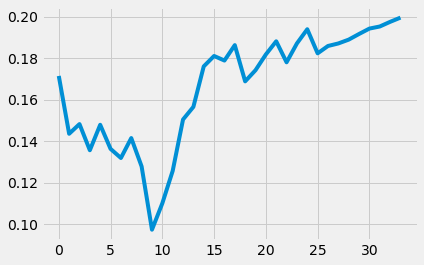

In [16]:
plt.plot(df_us_tests['ratio'].values)

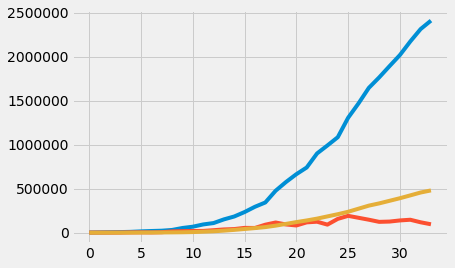

In [17]:
plt.plot(df_us_tests['tested'].values)
plt.plot(np.gradient(df_us_tests['tested'].values))
plt.plot(df_us_tests['positive'].values)

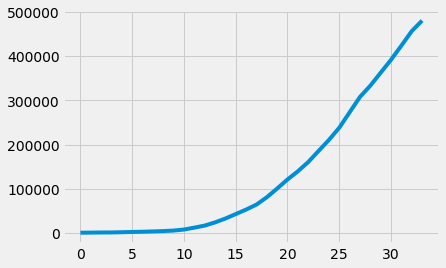

In [18]:
plt.plot(df_us_tests['positive'].values)

In [19]:
np.max(np.gradient(df_us_tests['tested'].values))

191751.5

In [20]:
np.max(df_us_tests['positive'].values)

480456

In [21]:
df_us_tests['positive'].values[-2]

456584

In [22]:
X1 = 5
Y1 = np.gradient(df_us_tests['tested'].values)[X1]
X2 = 13
Y2 = np.gradient(df_us_tests['tested'].values)[X2]
points = [(X1,Y1),(X2,Y2)]
degree = 3

print(f'X1,Y1 {X1,Y1}')
print(f'X2,Y2 {X2,Y2}')
test_base,A_factor = determine_R0(points)

X1,Y1 (5, 4801.5)
X2,Y2 (13, 37315.5)


In [23]:
test_base

1.292153301333399

In [24]:
line,coefs = return_polyfit(np.array([X1,X2]),np.array([Y1,Y2]),degree)
# poly.polyval(down_day, coefs)

/anaconda3/envs/torch/lib/python3.6/site-packages/ipykernel_launcher.py:27: RankWarning: The fit may be poorly conditioned


In [25]:
def decay_to_max(max_daily,last_point,duration):
    points = []
    new_point = last_point + ((max_daily - last_point) / 2)
    print('last_point',last_point,'new_point',new_point)
    for _ in range(duration):
        points.append(new_point)
        new_point += (max_daily - new_point) / 2
    return np.array(points)

last_point 134418.6324730965 new_point 142209.31623654824


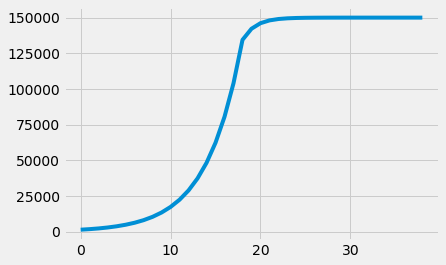

In [26]:
max_daily_tests = 150*1e+3
Ys = np.power(test_base,np.arange(19))*A_factor
end_ys = decay_to_max(max_daily_tests,Ys[-1],20)

projected_tests = np.concatenate([Ys,end_ys])
plt.plot(projected_tests)
# plt.yscale('log')

## Looking at infection cases

In [27]:
def gen_infection_scurve(params):
    population,R0,asymptomatic_period,hospitalization_rate,inflection_point,R0_reduction,base_R0,hospital_days = params.values()
    day = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=hospital_days)
    while 1:
        if day < inflection_point*asymptomatic_period:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
    #         print(f'hospitalized_patients {sum(hospitalized_patients)}')
        else:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
            R0 += (base_R0 - R0) / 2
            R0 = max(R0,base_R0)
        print(f'Day {day}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.2f}, R0 {R0:.2f}')
        yield (day,current_infections,total_infections,sum(hospitalized_patients),R0)
    

# Making the simulation more detailed

- add influx from travelers. Explains the reason why cases stay around 40-100
- add testing percentages. Start at zero and increase.
- add positive and negative rates for covid. 
- Assume hospitalized patients are always tested.

March 21
- 151k tests
- 26k cases

In [28]:
def return_testing_rate():
    pass

def gen_infection_adv(params):
    population,R0,asymptomatic_period,hospitalization_rate,inflection_point,R0_reduction,base_R0,hospital_days,tests,pos_rate,traveler_cases = params.values()
    day = 0
    down_day = 0
    total_confirmed = 0
    daily_confirmed = 0
    total_tests = 0
    current_tests = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=hospital_days)
    while 1:
        if day < inflection_point*asymptomatic_period:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
        else:
            current_infections = R0 * current_infections
            total_infections += current_infections
            day += asymptomatic_period
            down_day += asymptomatic_period
            hospitalized_patients.append(current_infections * hospitalization_rate)
            R0 += (base_R0 - R0) / 2
            R0 = max(R0,base_R0)
            current_tests = tests[down_day]
            total_tests += current_tests
            daily_confirmed = current_tests * pos_rate
            total_confirmed += daily_confirmed
        print(f'Day {day}, Total tests {total_tests:.0f}, Daily_tests {current_tests:.0f}, Daily confirmed {daily_confirmed:.0f}, Total confirmed {total_confirmed:.0f}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.0f}, R0 {R0:.2f}')
        yield (day,current_infections,total_infections,sum(hospitalized_patients),R0,daily_confirmed,total_confirmed,current_tests,total_tests)
    

In [29]:
population = 5
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 9 # of cycles since to Jan 24 to March 16
R0_reduction = 0.9
base_R0 = 0.80
hospital_days = 14
traveler_cases = 50

adv_params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days,
          'tests':projected_tests,
          'pos_rate':0.14,
        'traveler_cases':traveler_cases
         }

In [30]:
advGenerator = gen_infection_adv(adv_params)
advcurve_data = []
for _ in range(16):
    advcurve_data.append(next(advGenerator))

Day 5, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 12, total_infections: 16, Hospitalized_patients 1, R0 2.30
Day 10, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 26, total_infections: 43, Hospitalized_patients 2, R0 2.30
Day 15, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 61, total_infections: 104, Hospitalized_patients 5, R0 2.30
Day 20, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 140, total_infections: 244, Hospitalized_patients 12, R0 2.30
Day 25, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 322, total_infections: 566, Hospitalized_patients 28, R0 2.30
Day 30, Total tests 0, Daily_tests 0, Daily confirmed 0, Total confirmed 0, Current_infections: 740, total_infections: 1306, Hospitalized_patients 65, R0 2.30
Day 35, Total tests 0, Daily_tests 0, Daily confirmed 0, Tot

In [31]:
params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days
         }
curveGenerator = gen_infection_scurve(params)
scurve_data = []
for _ in range(25):
    scurve_data.append(next(curveGenerator))

Day 5, Current_infections: 12, total_infections: 16, Hospitalized_patients 0.58, R0 2.30
Day 10, Current_infections: 26, total_infections: 43, Hospitalized_patients 1.90, R0 2.30
Day 15, Current_infections: 61, total_infections: 104, Hospitalized_patients 4.94, R0 2.30
Day 20, Current_infections: 140, total_infections: 244, Hospitalized_patients 11.94, R0 2.30
Day 25, Current_infections: 322, total_infections: 566, Hospitalized_patients 28.03, R0 2.30
Day 30, Current_infections: 740, total_infections: 1306, Hospitalized_patients 65.04, R0 2.30
Day 35, Current_infections: 1702, total_infections: 3008, Hospitalized_patients 150.16, R0 2.30
Day 40, Current_infections: 3916, total_infections: 6924, Hospitalized_patients 345.93, R0 2.30
Day 45, Current_infections: 9006, total_infections: 15929, Hospitalized_patients 796.22, R0 2.30
Day 50, Current_infections: 20713, total_infections: 36643, Hospitalized_patients 1831.88, R0 1.55
Day 55, Current_infections: 32106, total_infections: 68748, Ho

In [32]:
def plot_projections(projections):
    data = [[] for _ in range(len(projections[0]))]
    print(len(data))
    for projection in projections:
        print('projection',projection)
        for i,d in enumerate(projection):
            data[i].append(d)
    return data

9
projection (5, 11.5, 16.5, 0.5750000000000001, 2.3, 0, 0, 0, 0)
projection (10, 26.45, 42.95, 1.8975, 2.3, 0, 0, 0, 0)
projection (15, 60.834999999999994, 103.785, 4.9392499999999995, 2.3, 0, 0, 0, 0)
projection (20, 139.92049999999998, 243.70549999999997, 11.935274999999999, 2.3, 0, 0, 0, 0)
projection (25, 321.8171499999999, 565.5226499999999, 28.026132499999996, 2.3, 0, 0, 0, 0)
projection (30, 740.1794449999998, 1305.7020949999996, 65.03510474999999, 2.3, 0, 0, 0, 0)
projection (35, 1702.4127234999994, 3008.1148184999993, 150.15574092499998, 2.3, 0, 0, 0, 0)
projection (40, 3915.5492640499983, 6923.664082549998, 345.9332041274999, 2.3, 0, 0, 0, 0)
projection (45, 9005.763307314995, 15929.427389864994, 796.2213694932498, 2.3, 0, 0, 0, 0)
projection (50, 20713.25560682449, 36642.68299668948, 1831.8841498344743, 1.5499999999999998, 672.21, 672.21, 4801.5, 4801.5)
projection (55, 32105.546190577952, 68748.22918726743, 3437.161459363372, 1.1749999999999998, 2421.4481632227953, 3093.65

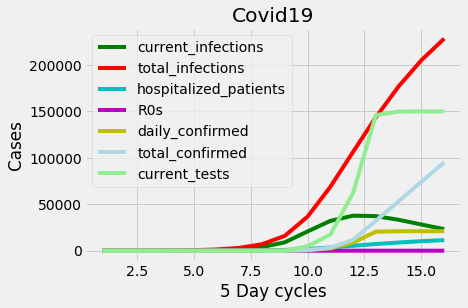

In [33]:
values = plot_projections(advcurve_data)
# (day,current_infections,total_infections,sum(hospitalized_patients),R0,daily_confirmed,total_confirmed,current_tests,total_tests)
labels = ['days','current_infections','total_infections','hospitalized_patients','R0s','daily_confirmed','total_confirmed','current_tests','total_tests']
colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
for i,x in enumerate(values[1:-1],1):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

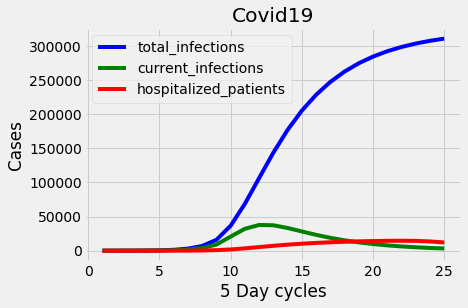

In [34]:
days,current_infections,total_infections,hospitalized_patients,R0s = [],[],[],[],[]
for point in scurve_data:
    day,current_infection,total_infection,hospitalized_patient,R0 = point
    days.append(day)
    current_infections.append(current_infection)
    total_infections.append(total_infection)
    hospitalized_patients.append(hospitalized_patient)
    R0s.append(R0)
    
values = [total_infections,current_infections,hospitalized_patients,R0s,days]
labels = ['total_infections','current_infections','hospitalized_patients','R0s','days']
colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
for i,x in enumerate(values[:-2]):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

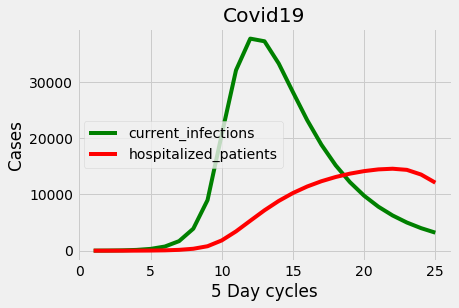

In [35]:
for i,x in enumerate(values[1:-2],1):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

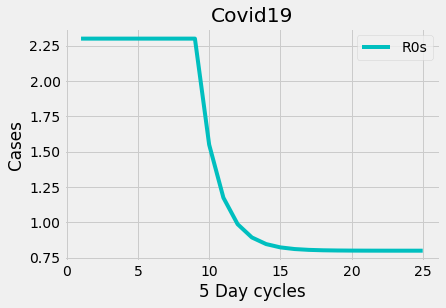

In [36]:
for i,x in enumerate(values[3:4],3):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"{labels[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

In [37]:
def gen_infections(population,R0,asymptomatic_period,hospitalization_rate):
    day = 0
    total_infections = population
    current_infections = population
    hospitalized_patients = deque(maxlen=10)
    while 1:
        current_infections = R0 * current_infections
        total_infections += current_infections
        day += asymptomatic_period
        hospitalized_patients.append(current_infections * hospitalization_rate)
#         print(f'hospitalized_patients {sum(hospitalized_patients)}')
        print(f'Day {day}, Current_infections: {current_infections:.0f}, total_infections: {total_infections:.0f}, Hospitalized_patients {sum(hospitalized_patients):.2f}')
        yield total_infections
    

In [38]:
population = 3
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
generator = gen_infections(population,R0,asymptomatic_period,hospitalization_rate)

In [39]:
for i in range(1,17):
    next(generator)
#     print(f'Infected population {next(generator)}, Day {i*5}')

Day 5, Current_infections: 7, total_infections: 10, Hospitalized_patients 0.34
Day 10, Current_infections: 16, total_infections: 26, Hospitalized_patients 1.14
Day 15, Current_infections: 37, total_infections: 62, Hospitalized_patients 2.96
Day 20, Current_infections: 84, total_infections: 146, Hospitalized_patients 7.16
Day 25, Current_infections: 193, total_infections: 339, Hospitalized_patients 16.82
Day 30, Current_infections: 444, total_infections: 783, Hospitalized_patients 39.02
Day 35, Current_infections: 1021, total_infections: 1805, Hospitalized_patients 90.09
Day 40, Current_infections: 2349, total_infections: 4154, Hospitalized_patients 207.56
Day 45, Current_infections: 5403, total_infections: 9558, Hospitalized_patients 477.73
Day 50, Current_infections: 12428, total_infections: 21986, Hospitalized_patients 1099.13
Day 55, Current_infections: 28584, total_infections: 50570, Hospitalized_patients 2528.00
Day 60, Current_infections: 65744, total_infections: 116314, Hospital

## Graphs with different initial populations

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.11
Day 10, Current_infections: 5, total_infections: 9, Hospitalized_patients 0.38
Day 15, Current_infections: 12, total_infections: 21, Hospitalized_patients 0.99
Day 20, Current_infections: 28, total_infections: 49, Hospitalized_patients 2.39
Day 25, Current_infections: 64, total_infections: 113, Hospitalized_patients 5.61
Day 30, Current_infections: 148, total_infections: 261, Hospitalized_patients 13.01
Day 35, Current_infections: 340, total_infections: 602, Hospitalized_patients 30.03
Day 40, Current_infections: 783, total_infections: 1385, Hospitalized_patients 69.19
Day 45, Current_infections: 1801, total_infections: 3186, Hospitalized_patients 159.24
Day 50, Current_infections: 4143, total_infections: 7329, Hospitalized_patients 366.38
Day 55, Current_infections: 9528, total_infections: 16857, Hospitalized_patients 842.67
Day 60, Current_infections: 21915, total_infections: 38771, Hospitalized_patients 19

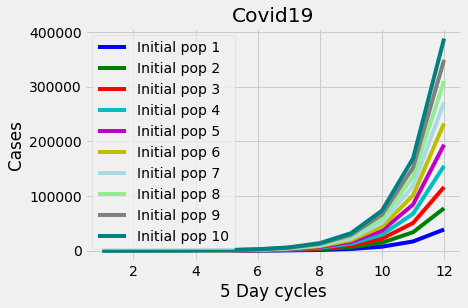

In [40]:
alternates = []
data_points = {i:[] for i in range(10)}
for i in range(1,11):
    alternates.append(gen_infections(i,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))
    

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
xs = data_points.values()
for i,x in enumerate(xs):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"Initial pop {i+1}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

## Different R0 values with pop 1

In [41]:
R0s = np.linspace(2,3,11)

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.10
Day 10, Current_infections: 4, total_infections: 7, Hospitalized_patients 0.30
Day 15, Current_infections: 8, total_infections: 15, Hospitalized_patients 0.70
Day 20, Current_infections: 16, total_infections: 31, Hospitalized_patients 1.50
Day 25, Current_infections: 32, total_infections: 63, Hospitalized_patients 3.10
Day 30, Current_infections: 64, total_infections: 127, Hospitalized_patients 6.30
Day 35, Current_infections: 128, total_infections: 255, Hospitalized_patients 12.70
Day 40, Current_infections: 256, total_infections: 511, Hospitalized_patients 25.50
Day 45, Current_infections: 512, total_infections: 1023, Hospitalized_patients 51.10
Day 50, Current_infections: 1024, total_infections: 2047, Hospitalized_patients 102.30
Day 55, Current_infections: 2048, total_infections: 4095, Hospitalized_patients 204.60
Day 60, Current_infections: 4096, total_infections: 8191, Hospitalized_patients 409.20
Day 5

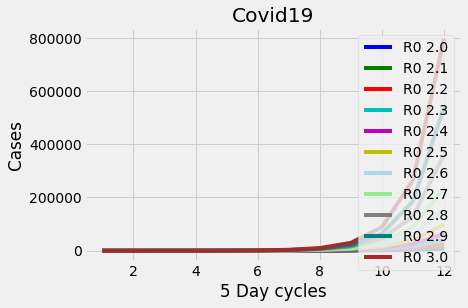

In [42]:
alternates = []
data_points = {i:[] for i in range(11)}
for R0 in R0s:
    alternates.append(gen_infections(1,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))
    

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal','brown']
xs = data_points.values()
for i,x in enumerate(xs):
    epochs = range(1,len(x)+1)
    plt.plot(epochs,x,colors[i],label=f"R0 {R0s[i]}")
    plt.title('Covid19')
    plt.xlabel('5 Day cycles')
    plt.ylabel('Cases')
    plt.legend()
plt.show()

# WHO projected R0

Day 5, Current_infections: 2, total_infections: 3, Hospitalized_patients 0.10
Day 10, Current_infections: 4, total_infections: 7, Hospitalized_patients 0.30
Day 15, Current_infections: 8, total_infections: 15, Hospitalized_patients 0.70
Day 20, Current_infections: 16, total_infections: 31, Hospitalized_patients 1.50
Day 25, Current_infections: 32, total_infections: 63, Hospitalized_patients 3.10
Day 30, Current_infections: 64, total_infections: 127, Hospitalized_patients 6.30
Day 35, Current_infections: 128, total_infections: 255, Hospitalized_patients 12.70
Day 40, Current_infections: 256, total_infections: 511, Hospitalized_patients 25.50
Day 45, Current_infections: 512, total_infections: 1023, Hospitalized_patients 51.10
Day 50, Current_infections: 1024, total_infections: 2047, Hospitalized_patients 102.30
Day 55, Current_infections: 2048, total_infections: 4095, Hospitalized_patients 204.60
Day 60, Current_infections: 4096, total_infections: 8191, Hospitalized_patients 409.20
Day 5

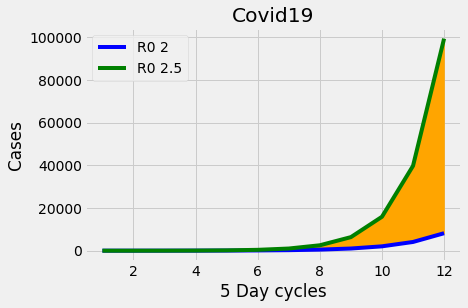

In [43]:
WHO_R0s = [2,2.5]

alternates = []
data_points = {i:[] for i in range(2)}
for R0 in WHO_R0s:
    alternates.append(gen_infections(1,R0,asymptomatic_period,hospitalization_rate))
for i,gen in enumerate(alternates):
    for _ in range(1,13):
        data_points[i].append(next(gen))

print(f'Max {np.max(data_points[0])}, {np.max(data_points[1])}')

colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal','brown']
epochs = range(1,len(data_points[0])+1)
plt.plot(epochs,data_points[0],colors[0],label=f"R0 {WHO_R0s[0]}")
plt.plot(epochs,data_points[1],colors[1],label=f"R0 {WHO_R0s[1]}")
plt.fill_between(epochs, data_points[0], data_points[1],color='orange')
plt.title('Covid19')
plt.xlabel('5 Day cycles')
plt.ylabel('Cases')
# plt.yscale("log")
plt.legend()
plt.show()

In [44]:
points = [(0,699.5),(16,110)]
result = determine_R0(points)
print(f'result {result}')

result (0.890815592993061, 699.5)


# List all the contained countries

In [45]:
general_df['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [46]:
France = general_df[general_df['Country/Region'] == 'France']
Spain = general_df[general_df['Country/Region'] == 'Spain']
Italy = general_df[general_df['Country/Region'] == 'Italy']
US = general_df[general_df['Country/Region'] == 'US']
China = general_df[general_df['Country/Region'] == 'China']

# USA

In [47]:
US

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,188172,213372,243762,275586,308853,337072,366667,396223,429052,461437


In [48]:
US_cases = US.iloc[:,4:]
US_totals = US_cases.sum(axis=0).values

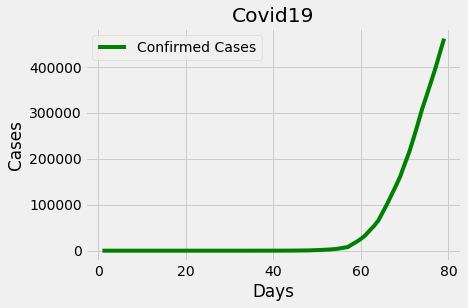

In [49]:
plot_totals(US_totals)

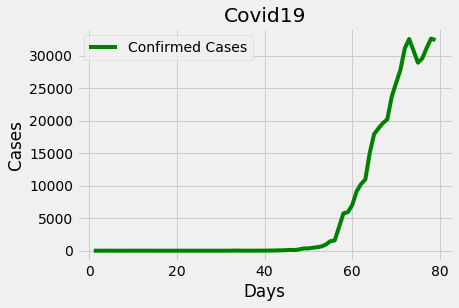

In [50]:
plot_totals(np.gradient(US_totals))

In [51]:
peak_US_index = np.argmax(np.gradient(US_totals))
print(f'Peak index {peak_US_index}')
print(f'Confirmed cases {US_totals[peak_US_index]}')

Peak index 77
Confirmed cases 429052


In [52]:
US_first_case_index = np.min(np.nonzero(US_totals))
print(f'Date of first case {US.columns[4+US_first_case_index]}')
print(f'Date of peak {US.columns[peak_US_index]}')
US_start_date = parse_date(US.columns[4+US_first_case_index])
US_peak_date = parse_date(US.columns[peak_US_index])
US_actual_start = datetime.datetime(2020,1,20)

print(f'Duration in days {US_peak_date - US_start_date}')
print(f'Duration since first case {datetime.datetime.now() - US_actual_start}')

Date of first case 1/22/20
Date of peak 4/4/20
Duration in days 73 days, 0:00:00
Duration since first case 81 days, 10:14:30.993596


# US States

In [53]:
USA_state_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200409,AK,235.0,6988.0,NaN,NaN,27.0,NaN,NaN,NaN,...,27.0,7223,7223,7223,2,0.0,0.0,146.0,9.0,155.0
1,20200409,AL,2769.0,18058.0,NaN,NaN,333.0,NaN,NaN,NaN,...,333.0,20827,20827,20827,1,8.0,19.0,1305.0,400.0,1705.0
2,20200409,AR,1119.0,13832.0,NaN,73.0,130.0,NaN,43.0,31.0,...,130.0,14951,14951,14951,5,3.0,0.0,302.0,119.0,421.0
3,20200409,AS,0.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,31,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200409,AZ,3018.0,34160.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,37178,37178,37178,4,9.0,0.0,2322.0,292.0,2614.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,20200302,WA,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,34,34,34,53,3.0,0.0,0.0,4.0,4.0
1940,20200301,RI,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,44,NaN,NaN,NaN,NaN,NaN
1941,20200301,WA,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,30,30,53,3.0,0.0,0.0,12.0,12.0
1942,20200229,WA,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,18,18,18,53,1.0,0.0,0.0,9.0,9.0


In [54]:
US_states = USA_state_df['state'].unique()
US_dates = USA_state_df['date'].unique()

In [55]:
print(US_dates[0])

20200409


In [56]:
def display_state_data(state):
    state_data = USA_state_df[USA_state_df['state'] == state]
    print(state_data)

In [60]:
display_state_data('NJ')

          date state  positive  negative  pending  hospitalizedCurrently  \
34    20200409    NJ   51027.0   56165.0      NaN                 7363.0   
90    20200408    NJ   47437.0   52979.0      NaN                 7026.0   
146   20200407    NJ   44416.0   50558.0      NaN                 7017.0   
202   20200406    NJ   41090.0   47942.0      NaN                 6390.0   
258   20200405    NJ   37505.0   44661.0      NaN                 4000.0   
314   20200404    NJ   34124.0   41232.0      NaN                 4000.0   
370   20200403    NJ   29895.0   37608.0      NaN                 3016.0   
426   20200402    NJ   25590.0   33520.0      NaN                 2000.0   
482   20200401    NJ   22255.0   30387.0      NaN                 2000.0   
538   20200331    NJ   18696.0   27077.0      NaN                 2000.0   
594   20200330    NJ   16636.0   25224.0      NaN                 2000.0   
650   20200329    NJ   13386.0   22216.0      NaN                 2000.0   
706   202003

In [58]:
[print(parse_date(date.astype(str))) for date in US_dates]

ValueError: time data '20200409' does not match format '%m/%d/%y'

# Italy

In [ ]:
Italy

In [ ]:
italy_cases = Italy.iloc[:,4:]
italy_totals = italy_cases.values[0]

In [ ]:
plot_totals(italy_totals)

In [ ]:
plot_totals(np.gradient(italy_totals))

In [ ]:
peak_italy_index = np.argmax(np.gradient(italy_totals))
print(f'Peak index {peak_italy_index}')
print(f'Confirmed cases {italy_totals[peak_italy_index]}')

In [ ]:
italy_first_case_index = np.min(np.nonzero(italy_totals))
italy_start_date = parse_date(Italy.columns[4+first_case_index])
italy_peak_date = parse_date(Italy.columns[4+peak_italy_index])
print(f'Date of first case {italy_start_date}')
print(f'Date of peak {italy_peak_date}')

print(f'Duration until peak {italy_peak_date - italy_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

# France

In [ ]:
France

In [ ]:
french_cases = France.iloc[:,4:]

In [ ]:
french_total = french_cases.sum(axis=0).values

In [ ]:
plot_totals(french_total)

In [ ]:
plot_totals(np.gradient(french_total))

In [ ]:
peak_france_index = np.argmax(np.gradient(french_total))
print(f'Peak index {peak_france_index}')
print(f'Confirmed cases {french_total[peak_france_index]}')

In [ ]:
first_case_index = np.min(np.nonzero(french_total))
france_start_date = parse_date(France.columns[4+first_case_index])
france_peak_date = parse_date(France.columns[4+peak_france_index])
print(f'Start index {first_case_index}')
print(f'Peak index {peak_france_index}')
print(f'Date of first case {france_start_date}')
print(f'Date of peak {france_peak_date}')

print(f'Duration in days {france_peak_date - france_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')

# Spain

In [ ]:
Spain

In [ ]:
spain_cases = Spain.iloc[:,4:]

In [ ]:
spain_totals = spain_cases.values[0]

In [ ]:
plot_totals(spain_totals)

In [ ]:
plot_totals(np.gradient(spain_totals))

#### Peak spain

In [ ]:
peak_spain_index = np.argmax(np.gradient(spain_totals))
print(f'Peak index {peak_spain_index}')
print(f'Confirmed cases {spain_totals[peak_spain_index]}')

In [ ]:
first_case_index = np.min(np.nonzero(spain_totals))
spain_start_date = parse_date(Spain.columns[4+first_case_index])
spain_peak_date = parse_date(Spain.columns[4+peak_spain_index])
print(f'Date of first case {Spain.columns[4+first_case_index]}')
print(f'Date of peak {Spain.columns[4+peak_spain_index]}')\

print(f'Duration in days {spain_peak_date - spain_start_date}')
print(f'Duration since first case {datetime.datetime.now() - spain_start_date}')

# China

Data is messy because of the big spike when they changed how they track the cases. better to average that data over the previous several datapoints to smooth out the curve

In [ ]:
China

In [ ]:
china_cases = China.iloc[:,4:]

In [ ]:
china_cases.shape

In [ ]:
china_totals = china_cases.sum(axis=0).values

# Fixing the china data

In [ ]:
data_spike_index = np.argmax(np.gradient(china_totals))

In [ ]:
data_spread_start = np.where(np.gradient(china_totals) == 3912.5)[0][0]

In [ ]:
print(f'data_spike_index {data_spike_index}, data_spread_start {data_spread_start}')

In [ ]:
print('Sum of the bad data gradients',sum(np.gradient(china_totals)[12:24]))
print('Average of the bad data gradients',sum(np.gradient(china_totals)[12:24]) / 13)
print('Sum of the bad data',sum(china_totals[12:24]))

## Goal is to spread the amounts in a cascade

In [ ]:
print(china_totals[12],china_totals[24])

In [ ]:
test = np.array([3786,4174,3728,3465,2922,2747,2615,2521,2404,2319,2210,2061])

In [ ]:
inputs = np.concatenate([np.array(china_totals[11]).reshape(1,),test])
print(sum(list(accumulate(inputs))))

In [ ]:
print(np.sum(test),test.shape)

In [ ]:
china_part1 = china_totals[:11]
china_part2 = np.gradient(china_totals)[24:]

In [ ]:
inputs = np.concatenate([np.array(china_totals[11]).reshape(1,),test,china_part2])
print(inputs.astype(int))

In [ ]:
china_inbetween = list(accumulate(inputs))

In [ ]:
print(china_inbetween)

In [ ]:
print(sum(china_inbetween),sum(china_totals[12:24]))

In [ ]:
new_china_totals = np.concatenate([china_part1,china_inbetween])

In [ ]:
print(new_china_totals.shape,china_totals.shape)
print(new_china_totals[12],new_china_totals[23])
print(china_totals[12],china_totals[23])

In [ ]:
print(np.gradient(new_china_totals).astype(int))

In [ ]:
new_china_totals

In [ ]:
np.gradient(china_totals)

In [ ]:
plot_totals(new_china_totals)

In [ ]:
plot_totals(np.gradient(new_china_totals))

# Find the R0 that fits the data the best

In [ ]:
chinaX1 = np.argmax(np.gradient(new_china_totals))
chinaY1 = np.gradient(new_china_totals)[chinaX1]
chinaX2 = 50
chinaY2 = np.gradient(new_china_totals)[chinaX2]
points = [(chinaX1,chinaY1),(chinaX2,chinaY2)]

print(f'X1,Y1 {chinaX1,chinaY1}')
print(f'X2,Y2 {chinaX2,chinaY2}')
china_R0 = determine_R0(points)


In [ ]:
china_R0

In [ ]:
yPoints = np.array([graph_expo(x,points) for x in np.arange(50)])

In [ ]:
yPoints[:11] = 0

## Hubei specifically

population 58.5M

In [ ]:
Hubei = China.loc[China['Province/State'].str.contains('Hubei')]

In [ ]:
Hubei

In [ ]:
Hubei_totals = Hubei.values[0][4:]

In [ ]:
plot_totals(Hubei_totals)

In [ ]:
plot_totals(np.gradient(Hubei_totals))

# Hubei peak

In [ ]:
Hubei

In [ ]:
Hubei_pop = 58.5*1e+7
peak_index = np.argmax(np.gradient(Hubei_totals))
Hubei_ratio = Hubei_totals/Hubei_pop
hubei_peak_date = datetime.datetime(2020,2,13)#parse_date(Hubei.columns[peak_index+4])
hubei_start_date = datetime.datetime(2019,11,17)
print(f'Peak index {peak_index}')
print(f'confirmed: {Hubei_totals[peak_index]}')
print(f'Total Hubei pop 58.5M')
print(f'confirmed: {Hubei_ratio[peak_index]}')
print(f'Peak Date {hubei_peak_date}')
print(f'Initial start Nov 17')
print(f'Number of days {(hubei_peak_date-hubei_start_date).days}')
print(f'Duration since first case {(datetime.datetime.now() - hubei_start_date).days}')



# Korea

## Pop 51.47M

## Seoul 9.77M

In [ ]:
def plot_comprehensive(data,labels,colors):
    epochs = range(1,len(data[0])+1)
    for i,label in enumerate(labels):
        plt.plot(epochs,data[i],colors[i],label=label)
    plt.title('Covid19')
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.legend()
    plt.show()

In [ ]:
Seoul_pop = 9.77*1e+7

In [ ]:
korea_df.tail()

In [ ]:
tests = korea_df['test'].values
negative = korea_df['negative'].values
confirmed = korea_df['confirmed'].values
released = korea_df['released'].values
deceased = korea_df['deceased'].values
headers = korea_df.columns[2:]
korea_data = [tests,negative,confirmed,released,deceased]
colors = ['b','g','r','c','m','b']

In [ ]:
plot_comprehensive(korea_data,headers,colors)

In [ ]:
plot_comprehensive([tests,negative],['tests','negative'],['b','g'])

In [ ]:
plot_comprehensive([confirmed,released,deceased],['confirmed','released','deceased'],['b','g','m'])

# Derivatives

In [ ]:
tests_derivative = np.gradient(tests)
negative_derivative = np.gradient(negative)
confirmed_derivative = np.gradient(confirmed)
released_derivative = np.gradient(released)
deceased_derivative = np.gradient(deceased)
korea_derivatives = [tests_derivative,negative_derivative,confirmed_derivative,released_derivative,deceased_derivative]


In [ ]:
plot_comprehensive(korea_derivatives,headers,colors)

In [ ]:
plot_comprehensive([confirmed_derivative,released_derivative,deceased_derivative],['confirmed','released','deceased'],['b','g','m'])


# Ratios with population

In [ ]:
ratios = [d/Seoul_pop for d in korea_data]
ratio_derivatives = [np.gradient(d) for d in ratios]

# When did korea reach its peak

In [ ]:
peak_index = np.argmax(confirmed_derivative)
print(f'Peak index {peak_index}')
print(f'tests: {tests[peak_index]}')
print(f'negative: {negative[peak_index]}')
print(f'confirmed: {confirmed[peak_index]}')
print(f'released: {released[peak_index]}')
print(f'deceased: {deceased[peak_index]}')
print(f'Total Seoul pop 9.77M')
print(f'tests: {ratios[0][peak_index]}')
print(f'negative: {ratios[1][peak_index]}')
print(f'confirmed: {ratios[2][peak_index]}')
print(f'released: {ratios[3][peak_index]}')
print(f'deceased: {ratios[4][peak_index]}')

In [ ]:
print(f'Korea first case {korea_df["date"][0]}')
print(f'Korea Peak date {korea_df["date"][peak_index]}')
korea_peak_date = datetime.date(2020,2,29)
korea_start_date = datetime.date(2020,1,20)
print(f'Days elapsed from start of transmission to peak {korea_peak_date - korea_start_date}')

In [ ]:
print(confirmed_derivative[40])
print(confirmed_derivative[56])
print(confirmed_derivative[40:])

In [ ]:
len(confirmed)
day_5s = confirmed[::5]
[print(f'day {i*5},infected {pop}') for i,pop in enumerate(day_5s)]
day_5s_dir = confirmed_derivative[::5]
[print(f'day {i*5},infected {pop}') for i,pop in enumerate(day_5s_dir)]

In [ ]:
generator = gen_infections(2,R0,asymptomatic_period,hospitalization_rate)
print(f'Infected population 1, Day 0')
for i in range(1,13):
    print(f'Infected population {next(generator)}, Day {i*5}')

# Predictions

using time series to predict the next number of cases

## Inputs

More informative

- current number of confirmed cases
- number of tests so far

Less informative

- current number of confirmed cases

## Extract and shape the data

In [ ]:
unique_dates = italy_df['Date'].unique()
# print('unique_dates',unique_dates)
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = italy_df[italy_df['Date'] == date]
    tests_preformed.append(rows['TestsPerformed'].sum())
    tests_positive.append(rows['TotalPositiveCases'].sum())

In [ ]:
korea_ml = np.stack([tests,confirmed])
italy_ml = np.stack([tests_preformed,tests_positive])
# china_ml =
usa_ml =  np.stack([USA_1df['posNeg'].values,USA_1df['positive'].values])

In [ ]:
print(korea_ml.shape,italy_ml.shape,usa_ml.shape)

# Networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable as V
from torch import optim
from torch.distributions import Categorical

In [ ]:
class Baseline(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(nS,hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1],nA)
        
    def forward(self,state):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)
    
class Convnet(nn.Module):
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Conv2d(nS,hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0],hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1],nA)
        
    def forward(self,state,mask):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

class LSTM():
    def __init__(self,seed,nS,nA,hidden_dims=(64,64),activation=F.leaky_relu):
        super(Baseline,self).__init__()
        self.activation = activation
        self.nS = nS
        self.nA = nA
        self.seed = torch.manual_seed(seed)
        self.lstm = nn.LSTM(nS,hidden_dims[0])
        
    def forward(self,state,mask):
        x = state
        if not isinstance(state,torch.Tensor):
            x = torch.tensor(x,dtype=torch.float32)
            x = x.unsqueeze(0)
        x,h = self.lstm(x)
        return x



# Train

In [ ]:
def run_sim(episodes,generator):
    infections = []
    for _ in range(episodes):
        day,current_infection,total_infection,hospitalized_patient,R0 = next(generator)
        infections.append(current_infection)
    return np.array(infections)
    
def get_loss(params,targets):  
    curveGenerator = gen_infection_scurve(params)
    episodes = len(targets)+params['inflection_point']
    infections = run_sim(episodes,curveGenerator)
    loss = np.sum(np.array(infections[params['inflection_point']:]) - targets)
    return loss

def tune_R0(params,training_params,targets,network):
    R0s = np.linspace(0.5,1,11)
    results = {R0:0 for R0 in R0s}
    for R0 in R0s:
        params['base_R0'] = R0
        loss = get_loss(params,targets)
        results[R0] = loss
#         print(f'loss {loss}, prev loss {prev_loss}, base_R0 {base_R0}')
#         print(f'new base {params["base_R0"]} * {0.0000001 * loss}')
#         params['base_R0'] = params['base_R0'] * (0.0000001 * loss)
    return results

In [ ]:

china_baseline = np.gradient(new_china_totals)
china_baseline_peak = np.argmax(np.gradient(new_china_totals))
korea_baseline = confirmed_derivative
korea_baseline_peak = np.argmax(korea_baseline)
print(f'China peak {china_baseline_peak}, shape of decline {china_baseline[china_baseline_peak:].shape}')
print(f'Korea peak {korea_baseline_peak}, shape of decline {korea_baseline[korea_baseline_peak:].shape}')

In [ ]:
korea_baseline[korea_baseline_peak:]
china_baseline[china_baseline_peak:]

In [ ]:
china_targets = china_baseline[china_baseline_peak:]
korea_targets = korea_baseline[korea_baseline_peak:]

population = 4
R0 = 2.3
asymptomatic_period = 5
hospitalization_rate = 0.05
inflection_point = 8 # of cycles since to Jan 24 to March 16
R0_reduction = 0.5
base_R0 = 0.9
hospital_days = 14

params = {'population':population,
         'R0':R0,
         'asymptomatic_period':asymptomatic_period,
         'hospitalization_rate':hospitalization_rate,
         'inflection_point':inflection_point,
         'R0_reduction':R0_reduction,
         'base_R0':base_R0,
          'hospital_days': hospital_days
         }

training_params = {'episodes':10}

tune_R0(params,training_params,china_targets,network)

# Compare outputs

In [ ]:
params['base_R0'] = 0.9
episodes = len(korea_targets)+params['inflection_point']
curveGenerator = gen_infection_scurve(params)
results = run_sim(episodes,curveGenerator)[params['inflection_point']+2:]

In [ ]:
print(results,'\n',china_targets)

In [ ]:
plt.plot(results)
plt.plot(china_targets)

In [ ]:
# def train(params):
#     for 

In [ ]:
nS = 2
nA = 1
seed = 1078
net = Baseline(seed,nS,nA)

In [ ]:
X = np.arange(len(china_targets))
y = china_targets
degree = 1
line,coefs = return_polyfit(X,y,degree)

In [ ]:
print(coefs)

In [ ]:
print(poly.polyval(1, coefs))

In [ ]:
plt.plot(line)
plt.plot(china_targets)